# Barra Factor Models: Size and Value #

In [23]:
# Import Libraries

# Data Management
import pandas as pd
import numpy as np

# Plots
import matplotlib.pyplot as plt

# Handle Files
import sys
import os

# Import Local Functions
sys.path.append(os.path.abspath("../source"))
from factors_toolkit import align_with_common_index

### First the Universe and the Mask ###

In [24]:
# Call the Universe Mask we are going to use
mask = pd.read_csv(r'..\additional_data\universe_mask.csv')
mask = mask.set_index('date')
mask.index = pd.to_datetime(mask.index)

mask

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
date,,,,,,,,,,,,,,,,,,,,,
2015-01-07,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,1,0,1
2015-01-13,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,1,0,1
2015-01-14,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,1,0,1
2015-01-15,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,1,0,1
2015-01-27,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-23,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2024-09-30,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2024-10-01,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [25]:
# Define the Variables we are going to use:

variables = [
    'Adjusted_close', 'Company Market Cap', 'Average Number of Shares Outstanding',
    'Price_to_Book', 'Price_to_Sales', 'Price_to_Earnings'
]

names = [
    'adj_close', 'market_cap', 'shares_outstanding',
    'price_to_book', 'price_to_sales', 'price_to_earnings'
]

In [26]:
# Create the DataFrames inside a dictionary
universe = {}
drops = []

# Create the Loop
for ticker in mask.columns:
    try:
        # Create the DataFrame
        df = pd.read_csv(r'..\stocks\{}.csv'.format(ticker))
        df = df.set_index('Date')                               # Set Index
        df.index = pd.to_datetime(df.index)                     # Index to date time
        df = df[variables]                                      # Use the variables we need
        df.columns = names                                      # Rename columns
        
        # Store Dataframe
        universe[ticker] = df.loc['2015':]
        
    except:
        drops.append(ticker)
        print("No data for", ticker)
    
    print(f'{ticker} is ready.')

A is ready.
AAPL is ready.
ABBV is ready.
ABT is ready.
ADBE is ready.
ADI is ready.
ADM is ready.
ADP is ready.
ADSK is ready.
AEE is ready.
AEP is ready.
AES is ready.
AFL is ready.
AIG is ready.
AIZ is ready.
AJG is ready.
AKAM is ready.
ALB is ready.
ALGN is ready.
ALL is ready.
AMAT is ready.
AMD is ready.
AME is ready.
AMGN is ready.
AMP is ready.
AMT is ready.
AMZN is ready.
ANET is ready.
ANSS is ready.
AOS is ready.
APA is ready.
APD is ready.
APH is ready.
APO is ready.
ARE is ready.
AWK is ready.
BALL is ready.
BDX is ready.
BK is ready.
BKNG is ready.
BLDR is ready.
BMY is ready.
BR is ready.
BRO is ready.
BSX is ready.
BWA is ready.
BX is ready.
BXP is ready.
C is ready.
CAG is ready.
CAH is ready.
CBRE is ready.
CCI is ready.
CDNS is ready.
CDW is ready.
CE is ready.
CF is ready.
CFG is ready.
CHD is ready.
CHRW is ready.
CHTR is ready.
CI is ready.
CINF is ready.
CL is ready.
CLX is ready.
CMCSA is ready.
CME is ready.
CMG is ready.
CMI is ready.
CMS is ready.
CNC is rea

In [27]:
print(len(universe))
print(len(drops))

399
0


### Functions ###

In [28]:
# Create a Function that Calculates the Market Cap Weighted Average
def market_cap_weighted_average(
        var_df: pd.DataFrame, 
        mkt_cap_df: pd.DataFrame,
        mask: pd.DataFrame,
) -> pd.Series:
    
    # Exclude stocks filtering by mask
    mkt_cap_adj = mkt_cap_df.fillna(0) * mask
    
    # Calculate the Weighted Mean
    numerator = (var_df * np.sqrt(mkt_cap_adj)).sum(axis=1)
    denominator = np.sqrt(mkt_cap_adj).sum(axis=1)
    
    return numerator / denominator

# Create a Function that Calculates the Standard Deviation
def standard_deviation(
        var_df: pd.DataFrame,
):
    
    return var_df.std(axis=1, ddof=1)

# Function to Standardize
def standardize_zscore(
        var_df: pd.DataFrame, 
        mkt_cap_df: pd.DataFrame,
        mask: pd.DataFrame,
) -> pd.DataFrame:
    # Calculate Market Cap Weighted Average
    wa = market_cap_weighted_average(var_df, mkt_cap_df, mask)
    
    # Calculate Cross-Sectional Standard Deviation
    std = standard_deviation(var_df)
    
    # Standardize (broadcasting Series across DataFrame rows)
    zscore_df = (var_df.subtract(wa, axis=0)).divide(std, axis=0)
    
    return zscore_df

# Winsorize Function
def custom_winsorize(df):
    df_winz = df.copy()
    data = df_winz.to_numpy()

    # Masks for each condition
    mask_gt_10 = data > 10
    mask_lt_minus10 = data < -10
    mask_5_to_10 = (data > 5) & (data <= 10)
    mask_minus10_to_minus5 = (data >= -10) & (data < -5)

    # Apply transformations
    data[mask_5_to_10] = 5
    data[mask_minus10_to_minus5] = -5
    data[mask_gt_10 | mask_lt_minus10] = np.nan

    # Return as DataFrame
    return pd.DataFrame(data, index=df.index, columns=df.columns)

# Standardization
def iterative_standardize_winsorize(
        var_df: pd.DataFrame, 
        mkt_cap_df: pd.DataFrame, 
        mask: pd.DataFrame,
        iterations: int = 3
) -> pd.DataFrame:
    result = var_df.copy()
    
    for i in range(iterations):
        result = standardize_zscore(result, mkt_cap_df, mask)
        result = custom_winsorize(result)
    
    # Last standardization
    result = standardize_zscore(result, mkt_cap_df, mask)
    
    return result

### Get Market Cap and Close Price Data ###

In [29]:
# Create the DataFrame for Market Capitalization
mktcap_series = []

for stock, df in universe.items():
    series = df['market_cap'].rename(stock)  
    mktcap_series.append(series)

# Concat
mktcap_df = pd.concat(mktcap_series, axis=1)

In [30]:
print(f'Total number of missing values: {mktcap_df.isna().sum().sum()}')
mktcap_df.isna().sum().sort_values(ascending=False)

Total number of missing values: 4929


MTCH    1379
LW       469
DELL     423
FTV      378
HPE      210
        ... 
CDW        0
SYF        0
TSLA       0
AWK        0
ZTS        0
Length: 399, dtype: int64

In [31]:
# Create the DataFrame for Adjusted Close Price
close_series = []

for stock, df in universe.items():
    series = df['adj_close'].rename(stock)  
    close_series.append(series)

# Concat
close_df = pd.concat(close_series, axis=1)

In [32]:
print(f'Total number of missing values: {close_df.isna().sum().sum()}')
close_df.isna().sum().sort_values(ascending=False)

Total number of missing values: 2000


LW      463
DELL    423
FTV     366
MTCH    223
HPE     200
       ... 
FFIV      0
FE        0
FDX       0
FDS       0
ZTS       0
Length: 399, dtype: int64

In [33]:
(mktcap_df.isna().sum() - close_df.isna().sum()).sort_values(ascending=False)

MTCH    1156
FTV       12
HPE       10
PYPL      10
CVX        6
        ... 
CFG        0
CDW        0
SYF        0
TSLA       0
ZTS        0
Length: 399, dtype: int64

Stocks with more missing values in adjusted close than in market cap —resulting in negative differences— might be delisted, which would explain the unavailability of their data.

In [34]:
# Create the DataFrame for Market Capitalization
shares_out_series = []

for stock, df in universe.items():
    series = df['shares_outstanding'].rename(stock)  
    shares_out_series.append(series)

# Concat
shares_out_df = pd.concat(shares_out_series, axis=1)
shares_out_df = shares_out_df.ffill()

In [35]:
print(f'Total number of missing values: {shares_out_df.isna().sum().sum()}')
shares_out_df.isna().sum().sort_values(ascending=False)

Total number of missing values: 1989


LW      509
AWK     399
DELL    280
FTV     232
HPE     192
       ... 
FFIV      0
FE        0
FDX       0
FDS       0
ZTS       0
Length: 399, dtype: int64

We are going to fill nans with the calculations:

    1) The Market Cap nans are going to be filled with the close price and the shares outstanding
    2) The Close Price nans are going to be filled with the market cap and the shares outstanding
  

In [36]:
# Get the calculated shares outstanding
cal_shares_outstanding = mktcap_df/close_df
cal_shares_outstanding = cal_shares_outstanding.ffill()

# Calculated Market Cap
cal_mktcap = cal_shares_outstanding.mul(close_df)

# Now we are going to use the calculated market cap to fill nans
filled_mktcap_df = mktcap_df.fillna(cal_mktcap)

In [37]:
print(f'Total number of missing values: {filled_mktcap_df.isna().sum().sum()}')
mktcap_df.isna().sum().sort_values(ascending=False)

Total number of missing values: 3194


MTCH    1379
LW       469
DELL     423
FTV      378
HPE      210
        ... 
CDW        0
SYF        0
TSLA       0
AWK        0
ZTS        0
Length: 399, dtype: int64

In [38]:
# Get the calculated close price
cal_close = shares_out_df.div(mktcap_df)

# Fill nans
filled_close_df = close_df.fillna(cal_close)

print(f'Total number of missing values: {filled_close_df.isna().sum().sum()}')
filled_close_df.isna().sum().sort_values(ascending=False)

Total number of missing values: 2000


LW      463
DELL    423
FTV     366
MTCH    223
HPE     200
       ... 
FFIV      0
FE        0
FDX       0
FDS       0
ZTS       0
Length: 399, dtype: int64

Some variables cannot be filled because the required data is not available.

In [42]:
# Finally, align the mask to the market cap data
mask = mask.reindex(mktcap_df.index).ffill().bfill()

mask

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
2015-01-05,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
2015-01-06,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
2015-01-07,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
2015-01-08,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2024-10-23,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2024-10-24,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


### Size: Logarithmic Market Capitalization ###

In [43]:
# Create the Log Market Capitalization
log_mktcap_df = np.log(filled_mktcap_df)

log_mktcap_df

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,23.334123,27.203970,25.377155,24.943681,24.302035,23.559815,24.159956,24.431034,23.307838,23.113587,...,22.026376,23.674862,23.438370,23.629933,26.681463,22.658517,24.193312,23.719963,22.134555,23.801148
2015-01-05,23.322227,27.179020,25.358157,24.952053,24.291962,23.549713,24.147382,24.426114,23.290877,23.109579,...,22.028113,23.676230,23.434404,23.621049,26.662058,22.594258,24.185797,23.722329,22.136044,23.795127
2015-01-06,23.308167,27.187860,25.353195,24.930542,24.284482,23.538201,24.148833,24.424151,23.291749,23.118243,...,22.039611,23.679506,23.443456,23.629103,26.658398,22.588360,24.181673,23.724521,22.159084,23.785323
2015-01-07,23.295700,27.184042,25.392816,24.923117,24.275946,23.537454,24.131492,24.421230,23.275397,23.127490,...,22.023282,23.672669,23.435347,23.637916,26.655505,22.596217,24.177533,23.711212,22.143086,23.805756
2015-01-08,23.268451,27.156527,25.403220,24.915637,24.280223,23.522770,24.126421,24.420811,23.262911,23.136652,...,22.007666,23.670747,23.428933,23.646652,26.646775,22.603734,24.165569,23.692259,22.143701,23.821037
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,24.331019,28.894962,26.532654,26.006440,26.069405,25.457105,24.024801,25.485358,24.839461,23.875431,...,23.832956,23.848015,23.126656,24.309263,26.997989,24.186149,24.353902,23.763487,23.653066,25.175957
2024-10-23,24.327792,28.873102,26.527981,26.014075,26.052883,25.466984,24.031780,25.480886,24.831858,23.891706,...,23.833096,23.854314,23.109200,24.319263,26.994420,24.188810,24.358839,23.767698,23.642500,25.173209
2024-10-24,24.310045,28.872278,26.537358,26.010050,26.048420,25.479382,24.039242,25.478780,24.830022,23.889574,...,23.976627,23.863067,23.111450,24.331471,26.988750,24.180653,24.352401,23.760990,23.625955,25.132771


In [44]:
# Now let us calculate the Weighted Average for Log Market Cap
wa_log_mktcap = market_cap_weighted_average(
    log_mktcap_df, 
    filled_mktcap_df,
    mask
).dropna()

wa_log_mktcap.name = 'average_mkt_cap'
wa_log_mktcap

Date
2015-01-02    24.651987
2015-01-05    24.643723
2015-01-06    24.640646
2015-01-07    24.636039
2015-01-08    24.629612
                ...    
2024-10-22    25.360880
2024-10-23    25.353073
2024-10-24    25.356184
2024-10-25    25.355043
2024-10-28    25.357591
Name: average_mkt_cap, Length: 2472, dtype: float64

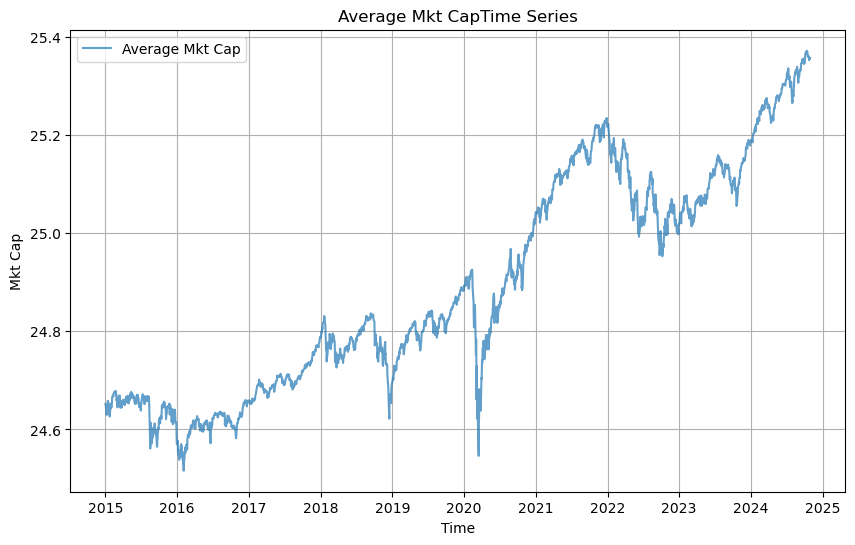

In [45]:
# Create Plot
plt.figure(figsize=(10, 6))
plt.plot(wa_log_mktcap, label='Average Mkt Cap', alpha=0.7)
# Config
plt.title('Average Mkt CapTime Series')
plt.xlabel('Time')
plt.ylabel('Mkt Cap')
plt.legend()
plt.grid()

# Show
plt.show()

In [46]:
# Now let's make the standardization
zscore_log_mktcap = standardize_zscore(log_mktcap_df, filled_mktcap_df, mask)

zscore_log_mktcap

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,-1.138170,2.204014,0.626290,0.251921,-0.302236,-0.943252,-0.424942,-0.190826,-1.160871,-1.328635,...,-2.267602,-0.843891,-1.048137,-0.882695,1.752752,-1.721656,-0.396134,-0.804940,-2.174174,-0.734825
2015-01-05,-1.143007,2.192865,0.617938,0.266685,-0.304250,-0.946247,-0.429302,-0.188217,-1.170122,-1.326933,...,-2.262330,-0.836817,-1.045981,-0.884546,1.745726,-1.772651,-0.396076,-0.796945,-2.168977,-0.733979
2015-01-06,-1.152142,2.202476,0.616113,0.250662,-0.307961,-0.953240,-0.425251,-0.187194,-1.166338,-1.316362,...,-2.249012,-0.831059,-1.035163,-0.874641,1.744671,-1.774531,-0.396855,-0.792137,-2.145709,-0.739564
2015-01-07,-1.159843,2.204877,0.654865,0.248418,-0.311602,-0.950645,-0.436603,-0.185883,-1.177412,-1.305401,...,-2.260911,-0.833638,-1.039002,-0.863711,1.747515,-1.765131,-0.396762,-0.800286,-2.157241,-0.718474
2015-01-08,-1.177218,2.185434,0.669064,0.247372,-0.302174,-0.957267,-0.435191,-0.180584,-1.182009,-1.291205,...,-2.267623,-0.829287,-1.038423,-0.850125,1.744569,-1.752106,-0.401334,-0.810682,-2.149972,-0.699307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,-0.934788,3.207829,1.063601,0.585964,0.643117,0.087342,-1.212736,0.112987,-0.473283,-1.348318,...,-1.386871,-1.373203,-2.027969,-0.954535,1.485978,-1.066284,-0.914017,-1.449927,-1.550154,-0.167851
2024-10-23,-0.931740,3.198880,1.067715,0.600695,0.635963,0.103518,-1.200746,0.116151,-0.473663,-1.328040,...,-1.381303,-1.362021,-2.039154,-0.939491,1.491599,-1.058043,-0.903526,-1.440734,-1.554510,-0.163454
2024-10-24,-0.949917,3.192693,1.072533,0.593725,0.628566,0.111867,-1.195813,0.111320,-0.477767,-1.331715,...,-1.252669,-1.355784,-2.038269,-0.930463,1.482407,-1.067409,-0.911458,-1.448472,-1.571087,-0.202864


In [47]:
# Now let us check the minimums and maximums
print(zscore_log_mktcap.max().max())
print(zscore_log_mktcap.min().min())

3.477536050824089
-4.896661109538151


### Value Ratios: Book to Price ###

In [49]:
# Create the DataFrame for Book to Price
ptb_series = []

for stock, df in universe.items():
    series = df['price_to_book'].rename(stock)  
    ptb_series.append(series)

# Concat
ptb_df = pd.concat(ptb_series, axis=1)

# Create Book to Price
btp_df = 1/ptb_df

In [50]:
print(f'Total number of missing values: {btp_df.isna().sum().sum()}')
btp_df.isna().sum().sort_values(ascending=False)

Total number of missing values: 3759


AWK     650
LW      559
DELL    488
FTV     366
MTCH    223
       ... 
FMC       0
FITB      0
FIS       0
FICO      0
ZTS       0
Length: 399, dtype: int64

We are going to fill the NANs with the calculated version of book to price

In [51]:
# Create Book Value
book_val = (btp_df * close_df)
book_val = book_val.ffill()

# Calculate the BtP Ratio
btp_ratio = book_val.div(close_df)

# Fill nans
filled_btp_df = btp_df.fillna(btp_ratio)

In [52]:
print(f'Total number of missing values: {filled_btp_df.isna().sum().sum()}')
filled_btp_df.isna().sum().sort_values(ascending=False)

Total number of missing values: 2761


AWK     650
LW      509
DELL    488
FTV     366
MTCH    223
       ... 
FI        0
FFIV      0
FE        0
FDX       0
ZTS       0
Length: 399, dtype: int64

In [53]:
# Standardization
zscore_book_to_price = standardize_zscore(
    filled_btp_df,
    filled_mktcap_df,
    mask
)

# Now let us check the minimums and maximums
print(zscore_book_to_price.max().max())
print(zscore_book_to_price.min().min())

19.826385919418275
-2.354753854842356


In [54]:
# 3-Times Standardization
zscore_book_to_price = iterative_standardize_winsorize(
    filled_btp_df,
    filled_mktcap_df,
    mask
)

In [55]:
# Now let us check the minimums and maximums
print(zscore_book_to_price.max().max())
print(zscore_book_to_price.min().min())

5.023942406043722
-2.470436962919546


### Value Ratios: Earnings to Price ###

In [56]:
# Create the DataFrame for Earnings to Price
pte_series = []

for stock, df in universe.items():
    series = df['price_to_earnings'].rename(stock)  
    pte_series.append(series)

# Concat
pte_df = pd.concat(pte_series, axis=1)

# Create Book to Price
etp_df = 1/pte_df

In [57]:
print(f'Total number of missing values: {etp_df.isna().sum().sum()}')
etp_df.isna().sum().sort_values(ascending=False)

Total number of missing values: 3955


AWK     587
LW      559
DELL    423
FTV     366
ERIE    253
       ... 
FI        0
FFIV      0
FE        0
FDX       0
ZTS       0
Length: 399, dtype: int64

In [58]:
# Create Earnings
earnings = (etp_df * close_df)
earnings = earnings.ffill()

# Calculate the EtP Ratio
etp_ratio = earnings.div(close_df)

# Fill nans
filled_etp_df = etp_df.fillna(etp_ratio)

In [59]:
print(f'Total number of missing values: {filled_etp_df.isna().sum().sum()}')
filled_etp_df.isna().sum().sort_values(ascending=False)

Total number of missing values: 2735


AWK     587
LW      509
DELL    423
FTV     366
MTCH    223
       ... 
FI        0
FFIV      0
FE        0
FDX       0
ZTS       0
Length: 399, dtype: int64

In [60]:
# Standardization
zscore_earnings_to_price = standardize_zscore(
    filled_etp_df,
    filled_mktcap_df,
    mask
)

# Now let us check the minimums and maximums
print(zscore_earnings_to_price.max().max())
print(zscore_earnings_to_price.min().min())

8.403544728570663
-19.65994807915934


In [61]:
# 3-Times Standardization
zscore_earnings_to_price = iterative_standardize_winsorize(
    filled_etp_df,
    filled_mktcap_df,
    mask
)

In [62]:
# Now let us check the minimums and maximums
print(zscore_earnings_to_price.max().max())
print(zscore_earnings_to_price.min().min())

5.604583195464353
-5.617326848799684


### Value Ratios: Sales to Price ###

In [63]:
# Create the DataFrame for Sales to Price
pts_series = []

for stock, df in universe.items():
    series = df['price_to_sales'].rename(stock)  
    pts_series.append(series)

# Concat
pts_df = pd.concat(pts_series, axis=1)

# Create Sales to Price
stp_df = 1/pts_df

In [64]:
print(f'Total number of missing values: {stp_df.isna().sum().sum()}')
stp_df.isna().sum().sort_values(ascending=False)

Total number of missing values: 4500


AWK     650
LW      559
DELL    488
FTV     366
ERIE    253
       ... 
FIS       0
FICO      0
FI        0
FFIV      0
ZTS       0
Length: 399, dtype: int64

In [65]:
# Create Sales
sales = (stp_df * close_df)
sales = sales.ffill()

# Calculate the StP Ratio
stp_ratio = sales.div(close_df)

# Fill nans
filled_stp_df = stp_df.fillna(stp_ratio)

In [66]:
print(f'Total number of missing values: {filled_stp_df.isna().sum().sum()}')
filled_stp_df.isna().sum().sort_values(ascending=False)

Total number of missing values: 2863


AWK     650
LW      509
DELL    488
FTV     366
MTCH    223
       ... 
FI        0
FFIV      0
FE        0
FDX       0
ZTS       0
Length: 399, dtype: int64

In [67]:
# Standardization
zscore_sales_to_price = standardize_zscore(
    filled_stp_df,
    filled_mktcap_df,
    mask
)

# Now let us check the minimums and maximums
print(zscore_sales_to_price.max().max())
print(zscore_sales_to_price.min().min())

15.143421718976988
-0.901140662346451


In [68]:
# 3-Times Standardization
zscore_sales_to_price = iterative_standardize_winsorize(
    filled_stp_df,
    filled_mktcap_df,
    mask
)

In [69]:
# Now let us check the minimums and maximums
print(zscore_sales_to_price.max().max())
print(zscore_sales_to_price.min().min())

5.27282045933278
-0.9221537176429675


### Calculate Value Factor ###

In [70]:
# Build the Value Factor
value_factor = pd.concat(
    [
        zscore_book_to_price,
        zscore_earnings_to_price,
        zscore_sales_to_price
    ]
).groupby(level=0).mean()

value_factor

,A,AAPL,ABBV,ABT,ADBE,ADI,ADM,ADP,ADSK,AEE,...,WST,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-02,-0.147001,-0.331052,-0.701190,-0.292925,-0.900640,-0.484735,1.034993,-0.591904,-0.868784,0.189807,...,-0.453109,0.217174,-0.511311,0.192847,0.561195,-0.320098,-0.234671,-0.401727,-0.556905,-0.813599
2015-01-05,-0.147147,-0.321216,-0.697273,-0.309413,-0.899573,-0.482762,1.066809,-0.600002,-0.864872,0.175275,...,-0.454480,0.187421,-0.509876,0.180286,0.572463,-0.276524,-0.232172,-0.444177,-0.557052,-0.813972
2015-01-06,-0.138650,-0.326954,-0.695735,-0.305329,-0.892277,-0.469468,1.090126,-0.597297,-0.857333,0.179069,...,-0.445706,0.177175,-0.497591,0.160627,0.565504,-0.277553,-0.226452,-0.442304,-0.555375,-0.809816
2015-01-07,-0.140501,-0.328526,-0.708188,-0.301300,-0.888061,-0.467519,1.084300,-0.593640,-0.849307,0.184011,...,-0.447429,0.187542,-0.508491,0.164562,0.566799,-0.272522,-0.246117,-0.450929,-0.562531,-0.810689
2015-01-08,-0.152964,-0.346070,-0.705472,-0.304021,-0.892394,-0.468036,1.162391,-0.597634,-0.853576,0.204627,...,-0.449508,0.198780,-0.504782,0.173748,0.570960,-0.263262,-0.245485,-0.446198,-0.565644,-0.811168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-22,-0.266443,-0.517957,-0.599633,-0.277883,-0.517733,-0.313967,2.626581,-0.443284,-0.600219,0.292938,...,-0.414380,0.082546,0.135981,0.364426,0.586339,-0.144576,-0.612650,0.398117,-0.437203,-0.485801
2024-10-23,-0.266393,-0.511594,-0.598790,-0.283787,-0.512978,-0.320204,2.583388,-0.442588,-0.598567,0.270537,...,-0.415457,0.073539,0.148235,0.347836,0.585238,-0.148606,-0.614401,0.388291,-0.433882,-0.485570
2024-10-24,-0.259779,-0.515633,-0.607292,-0.286744,-0.517096,-0.335066,2.573139,-0.445560,-0.604553,0.269706,...,-0.478137,-0.031707,0.152015,0.330787,0.593864,-0.149448,-0.613593,0.392376,-0.434773,-0.475791


In [71]:
print(f'Total number of missing values: {value_factor.isna().sum().sum()}')
value_factor.isna().sum().sort_values(ascending=False)

Total number of missing values: 2633


AWK     587
LW      509
DELL    423
FTV     366
MTCH    223
       ... 
FI        0
FFIV      0
FE        0
FDX       0
ZTS       0
Length: 399, dtype: int64

In [72]:
# Standardization
zscore_value_factor = standardize_zscore(
    value_factor,
    filled_mktcap_df,
    mask
)

# Now let us check the minimums and maximums
print(zscore_value_factor.max().max())
print(zscore_value_factor.min().min())

7.1135957975785375
-6.059541692616149


In [73]:
# 3-Times Standardization
zscore_value_factor = iterative_standardize_winsorize(
    value_factor,
    filled_mktcap_df,
    mask
)

In [74]:
# Now let us check the minimums and maximums
print(zscore_value_factor.max().max())
print(zscore_value_factor.min().min())

5.0085595380723476
-5.000296107262552


In [75]:
# Create the Dictionary

descriptors_dict = {
    'mask': mask,
    'mktcap': filled_mktcap_df,
    'size_factor': zscore_log_mktcap,
    'value_factor': zscore_value_factor,
}

descriptors_dict

{'mask':               A  AAPL  ABBV  ABT  ADBE  ADI  ADM  ADP  ADSK  AEE  ...  WST  \
 Date                                                              ...        
 2015-01-02  1.0   1.0   1.0  1.0   1.0  1.0  1.0  1.0   1.0  1.0  ...  0.0   
 2015-01-05  1.0   1.0   1.0  1.0   1.0  1.0  1.0  1.0   1.0  1.0  ...  0.0   
 2015-01-06  1.0   1.0   1.0  1.0   1.0  1.0  1.0  1.0   1.0  1.0  ...  0.0   
 2015-01-07  1.0   1.0   1.0  1.0   1.0  1.0  1.0  1.0   1.0  1.0  ...  0.0   
 2015-01-08  1.0   1.0   1.0  1.0   1.0  1.0  1.0  1.0   1.0  1.0  ...  0.0   
 ...         ...   ...   ...  ...   ...  ...  ...  ...   ...  ...  ...  ...   
 2024-10-22  1.0   1.0   1.0  1.0   1.0  1.0  1.0  1.0   1.0  1.0  ...  1.0   
 2024-10-23  1.0   1.0   1.0  1.0   1.0  1.0  1.0  1.0   1.0  1.0  ...  1.0   
 2024-10-24  1.0   1.0   1.0  1.0   1.0  1.0  1.0  1.0   1.0  1.0  ...  1.0   
 2024-10-25  1.0   1.0   1.0  1.0   1.0  1.0  1.0  1.0   1.0  1.0  ...  1.0   
 2024-10-28  1.0   1.0   1.0  1.0   1.0  1.0

In [76]:
# Store dict

import pickle

with open(r'..\additional_data\factors.pkl', 'wb') as f:
    pickle.dump(descriptors_dict, f)